In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

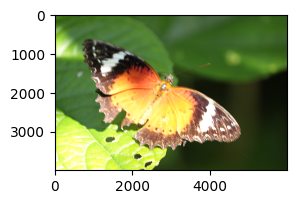

In [35]:
image = imread("/content/drive/MyDrive/Dataset/test/kupu_batik_cap/Kupu Batik Cap-10.JPG")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [36]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('/content/drive/MyDrive/Dataset/train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['kupu_batik_cap', 'kupu_harimau_kuning_hijau', 'kupu_hijau_biru', 'kupu_jarak', 'kupu_jojo', 'kupu_pantat_merah', 'kupu_raja_helena', 'kupu_raja_limau']

for i,label in enumerate(labels):
    folder = os.path.join("/content/drive/MyDrive/Dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 294 images belonging to 8 classes.
Found 68 images belonging to 8 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 8)
Bentuk array dari dataset validation (validasi) adalah: (68, 224, 224, 3) (68, 8)
Bentuk array dari dataset test (pengujian) adalah: (91, 224, 224, 3) (91,)


In [37]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'kupu_batik_cap': 0, 'kupu_harimau_kuning_hijau': 1, 'kupu_hijau_biru': 2, 'kupu_jarak': 3, 'kupu_jojo': 4, 'kupu_pantat_merah': 5, 'kupu_raja_helena': 6, 'kupu_raja_limau': 7}


In [38]:
!cat labels.txt

kupu_batik_cap
kupu_harimau_kuning_hijau
kupu_hijau_biru
kupu_jarak
kupu_jojo
kupu_pantat_merah
kupu_raja_helena
kupu_raja_limau

In [40]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [26]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [42]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

In [44]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 32)          147488    
                                                                 
 global_average_pooling2d_3   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 14,862,440
Trainable params: 14,862,440
Non-trainable params: 0
_________________________________________________________________


In [45]:
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
#ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit_generator(train_generator, 
                    epochs=10, 
                    validation_data=val_generator)
#history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
3/3 [==============================] - 750s 229s/step - loss: 2.7881 - acc: 0.1565 - val_loss: 2.0903 - val_acc: 0.1618
Epoch 2/10
3/3 [==============================] - 707s 299s/step - loss: 2.2358 - acc: 0.1599 - val_loss: 2.0700 - val_acc: 0.1471
Epoch 3/10
3/3 [==============================] - 754s 216s/step - loss: 2.1301 - acc: 0.1327 - val_loss: 2.0837 - val_acc: 0.1618
Epoch 4/10
3/3 [==============================] - 748s 221s/step - loss: 2.0784 - acc: 0.1531 - val_loss: 2.0694 - val_acc: 0.1618
Epoch 5/10
3/3 [==============================] - 753s 216s/step - loss: 2.0903 - acc: 0.1327 - val_loss: 2.0662 - val_acc: 0.1618
Epoch 6/10
3/3 [==============================] - 751s 215s/step - loss: 2.0684 - acc: 0.1497 - val_loss: 2.1135 - val_acc: 0.1618
Epoch 7/10
3/3 [==============================] - 749s 222s/step - loss: 2.1218 - acc: 0.1497 - val_loss: 2.1133 - val_acc: 0.1618
Epoch 8/10
3/3 [==============================] - 749s 223s/step - loss: 2.1047 - a

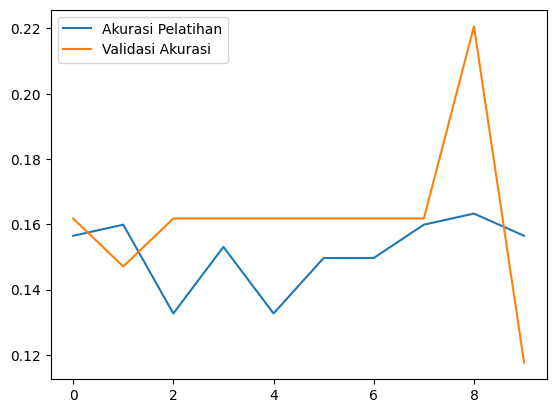

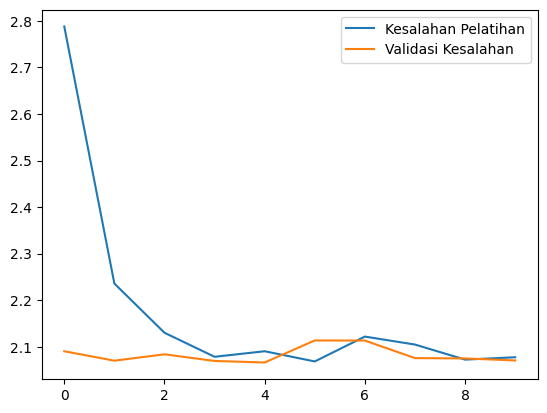

In [46]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [47]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 30


In [48]:
print(train_generator)

In [49]:
#Prediksi Label Validasi dengan Pelatihan
n = 44
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 0. 0. 0. 0. 0. 0. 1.]
Prediksinya adalah [0.10801881 0.12285612 0.13475025 0.12111485 0.12713772 0.13834144
 0.11753581 0.13024499]


In [50]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
3/3 [==============================] - 221s 48s/step - loss: 2.0700 - acc: 0.1224
[2.070035457611084, 0.12244898080825806]
1/1 [==============================] - 58s 58s/step - loss: 2.0705 - acc: 0.1176
[2.070481061935425, 0.11764705926179886]
3/3 [==============================] - 49s 16s/step - loss: 2.0381 - acc: 0.3297
[2.0381336212158203, 0.32967033982276917]


In [51]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 6 6 6 6 7 7 7 7 7 7]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


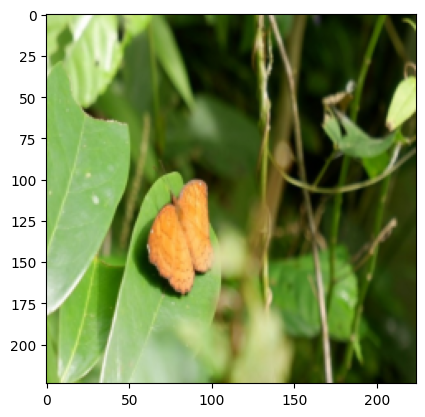

Label yang benar adalah: 3 : kupu_jarak
Nilai yang diprediksi adalah: [0.10643137 0.12219141 0.13477428 0.12146774 0.12901974 0.13914396
 0.11652561 0.13044588]
Label yang diprediksi adalah: 5 : kupu_pantat_merah
Prediksi salah


In [52]:
n = 44 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


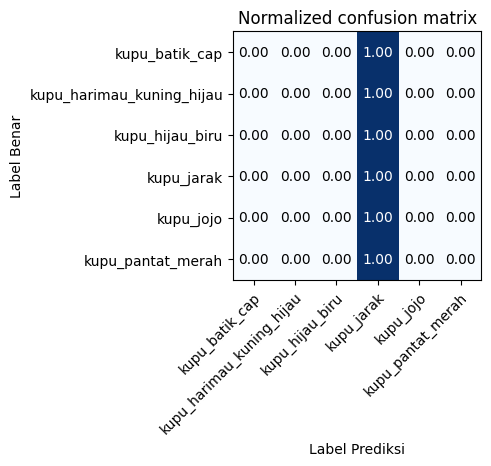

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [54]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_kupu_kupu.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/model/assets
